In [1]:
!pip install nengolib

     |████████████████████████████████| 122kB 17.1MB/s 
     |████████████████████████████████| 378kB 28.5MB/s 


In [34]:
import torch
import torch.nn as nn
from sympy.matrices import Matrix, eye, zeros, ones, diag, GramSchmidt
import numpy as np
from functools import partial
import torch.nn.functional as F
import math

from nengolib.signal import Identity, cont2discrete
from nengolib.synapses import LegendreDelay
from functools import partial

def lecun_uniform(tensor):
    fan_in = nn.init._calculate_correct_fan(tensor, 'fan_in')
    nn.init.uniform_(tensor, -math.sqrt(3 / fan_in), math.sqrt(3 / fan_in))
    
class LegendreMemoryUnitCell(nn.Module):
  def __init__(self, input_dim, units , order, theta,
                 input_encoders_initializer=lecun_uniform,
                 hidden_encoders_initializer=lecun_uniform,
                 memory_encoders_initializer=partial(torch.nn.init.constant_, val=0),
                 input_kernel_initializer=torch.nn.init.xavier_normal_,
                 hidden_kernel_initializer=torch.nn.init.xavier_normal_,
                #  hidden_kernel_initializer=torch.nn.init.uniform_,
                 include_bias=False, #added by ali acc to branch
                 memory_kernel_initializer=torch.nn.init.xavier_normal_):
    super(LegendreMemoryUnitCell, self).__init__()

    self.order = order
    self.theta = theta
    self.units = units
    self.include_bias=include_bias

    realizer = Identity()
    self._realizer_result = realizer(LegendreDelay(theta=theta, order=self.order))

    self._ss = cont2discrete(self._realizer_result.realization, dt=1., method='zoh')

    self._A = self._ss.A - np.eye(order)
    self._B = self._ss.B
    self._C = self._ss.C

    self.AT = nn.Parameter(torch.Tensor(self._A), requires_grad=False)
    self.BT = nn.Parameter(torch.Tensor(self._B), requires_grad=False)

    if self.include_bias:
      self.bias = nn.Parameter(torch.Tensor(1, self.units),requires_grad=True) #added by ali for the fix given in github issue

    self.encoder_input = nn.Parameter(torch.Tensor(1,input_dim), requires_grad=True)
    self.encoder_hidden = nn.Parameter(torch.Tensor(1,self.units), requires_grad=True)
    self.encoder_memory = nn.Parameter(torch.Tensor(1,self.order ), requires_grad=True)
    self.kernel_input = nn.Parameter(torch.Tensor(self.units, input_dim), requires_grad=True)
    self.kernel_hidden = nn.Parameter(torch.Tensor(self.units, self.units), requires_grad=True)
    self.kernel_memory = nn.Parameter(torch.Tensor(self.units, self.order), requires_grad=True)
    
    if self.include_bias:
      torch.nn.init.constant_(self.bias, 0)

    input_encoders_initializer(self.encoder_input)
    hidden_encoders_initializer(self.encoder_hidden)
    memory_encoders_initializer(self.encoder_memory)
    input_kernel_initializer(self.kernel_input)
    hidden_kernel_initializer(self.kernel_hidden)
    memory_kernel_initializer(self.kernel_memory)

  def EulerOdeSolver(self):
    A_hat = (self.step_delta_t/self.theta)*self.AT + torch.eye(self.order,self.d_order_ode)
    B_hat = (self.step_delta_t/self.theta)*self.BT

    return A_hat, B_hat

  def forward(self, xt, states):
    ht, mt = states

    ut = F.linear(xt, self.encoder_input)+F.linear(ht, self.encoder_hidden)+  F.linear(mt, self.encoder_memory)


    mt = mt + F.linear(mt, self.AT) + F.linear(ut, self.BT)

    ht = nn.Tanh()(F.linear(xt, self.kernel_input) + F.linear(ht, self.kernel_hidden) + F.linear(mt, self.kernel_memory)+(self.bias if self.include_bias else 0))
    
    return ht, (ht, mt)

class LegendreMemoryUnit(nn.Module):
  def __init__(self, input_dim, units , order, theta):
    super(LegendreMemoryUnit, self).__init__()

    self.units = units
    self.order = order

    self.lmucell = LegendreMemoryUnitCell(input_dim, units , order, theta,include_bias=False)

  def forward(self, xt):
    outputs = []
    
    h0 = torch.zeros(xt.size(0),self.units).cuda()
    m0 = torch.zeros(xt.size(0),self.order).cuda()
    states = (h0,m0)
    for i in range(xt.size(1)):
      out, states = self.lmucell(xt[:,i,:], states)
      outputs += [out]
    return torch.stack(outputs).permute(1,0,2), states
    # return torch.stack(outputs).permute(1,0,2), states


# Test LMU output

In [18]:
x = torch.rand(64,5000,1).to(torch.device("cuda:0"))
h0 = torch.rand(64,49).to(torch.device("cuda:0"))
m0 = torch.rand(64,4).to(torch.device("cuda:0"))
model = LegendreMemoryUnit(1,49,4,4).to(torch.device("cuda:0"))
res, _ = model(x)
print(res.shape)

torch.Size([64, 5000, 49])


# Models LSTM - LMU

In [35]:
class LMUModel(nn.Module):
  def __init__(self):
    super(LMUModel, self).__init__()
    self.LMU = LegendreMemoryUnit(1,49,4,4)
    self.dense = nn.Linear(49,1)

  def forward(self,x):
    x, _ = self.LMU(x)
    x = self.dense(x)

    return x

model_lstm = LMUModel()

print("number of parameters : ", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))
print()


number of parameters :  2750



In [25]:
class LSTMModel(nn.Module):
  def __init__(self):
    super(LSTMModel, self).__init__()
    self.LSTM = nn.LSTM(1,25,1,batch_first=True)
    self.dense = nn.Linear(25,1)

  def forward(self,x):
    x, _ = self.LSTM(x)
    x = self.dense(x)

    return x
    
model_lstm = LSTMModel()

print("number of parameters : ", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))
print()


Nombre de paramètres :  2826



# MackeyGlass Datas

Took from official LMU (tensorflow) repo

(64, 5000, 1) (64, 5000, 1)


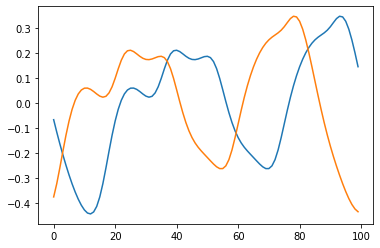

In [20]:
import collections 
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.initializers import RandomUniform
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from torchsummary import summary

def mackey_glass(sample_len=1000, tau=17, delta_t=10, seed=None, n_samples=1):
    # Adapted from https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

def generate_data(n_batches, length, split=0.5, seed=0,
                  predict_length=15, tau=17, washout=100, delta_t=1,
                  center=True):
    X = np.asarray(mackey_glass(
        sample_len=length+predict_length+washout, tau=tau,
        seed=seed, n_samples=n_batches))
    X = X[:, washout:, :]
    cutoff = int(split*n_batches)
    if center:
        X -= np.mean(X)  # global mean over all batches, approx -0.066
    Y = X[:, predict_length:, :]
    X = X[:, :-predict_length, :]
    assert X.shape == Y.shape
    return ((X[:cutoff], Y[:cutoff]),
            (X[cutoff:], Y[cutoff:]))

(train_X, train_Y), (test_X, test_Y) = generate_data(128, 5000)
print(train_X.shape, test_X.shape)

def cool_plot(X, Y, title=""):
    plt.figure(figsize=(14, 8))
    plt.title(title)
    plt.scatter(X[:, 0], Y[:, 0] - X[:, 0], s=8, alpha=0.7,
                c=np.arange(X.shape[0]), cmap=sns.cubehelix_palette(as_cmap=True))
    plt.plot(X[:, 0], Y[:, 0] - X[:, 0], c='black', alpha=0.2)
    plt.xlabel("$x(t)$")
    plt.ylabel("$y(t) - x(t)$")
    sns.despine(offset=15)
    
    plt.show()

# cool_plot(train_X[0], train_Y[0])

plt.plot(train_X[0][0:100])
plt.plot(train_Y[0][0:100])
plt.show()



# Utils

In [32]:
def train(model, epochs, dataset, dataset_valid = None):
  for e in range(epochs):
      model.train()
      running_loss = 0
      with tqdm(total=len(dataset)) as bar:
        for i, (X, y) in enumerate(dataset):
            optimizer.zero_grad()
            
            output = model(X.cuda())

            loss_ll = criterion(output, y.cuda())
            
            loss_ll.backward()
            
            optimizer.step()
            
            running_loss += loss_ll.item()

            bar.update(1)
            bar.set_description("Epoch {} - Training loss: {}".format(e, running_loss/len(dataset)))

      model.eval()
      running_loss = 0
      outs = []
      with tqdm(total=len(dataset_valid)) as bar:
        for i, (X, y) in enumerate(dataset_valid):
            optimizer.zero_grad()
            
            output = model(X.cuda())

            loss_ll = criterion(output, y.cuda())
                
            running_loss += loss_ll.item()
            
            outs.append(output)
            bar.update(1)
            bar.set_description("Epoch {} - Validation loss: {}".format(e, running_loss/len(dataset_valid)))


# Test LMU vs LSTM on MackeyGlass

In [36]:
from tqdm import tqdm
import torch.utils.data as data



model = LMUModel().cuda()
print("\n\number of paramaters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X).cuda(), torch.Tensor(train_Y).cuda())
dataset = data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X).cuda(), torch.Tensor(test_Y).cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 100, dataset, dataset_valid)

  0%|          | 0/2 [00:00<?, ?it/s]



umber of paramaters :  2750





Epoch 33 - Training loss: 0.007807926274836063: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]
Epoch 33 - Validation loss: 0.0077192934695631266: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]
Epoch 34 - Training loss: 0.007736204424872994: 100%|██████████| 2/2 [00:06<00:00,  3.16s/it]
Epoch 34 - Validation loss: 0.0076392225455492735: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]
Epoch 35 - Training loss: 0.00764695811085403: 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]
Epoch 35 - Validation loss: 0.0075552467023953795: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]
Epoch 56 - Training loss: 0.00631895731203258: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]
Epoch 56 - Validation loss: 0.0059003999922424555: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]
Epoch 60 - Training loss: 0.005790394498035312: 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]
Epoch 60 - Validation loss: 0.0056936233304440975: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]
Epoch 65 - Training loss: 0.005392070626839995:

KeyboardInterrupt: ignored

In [26]:
from tqdm import tqdm
import torch.utils.data as data



model = LSTMModel().cuda()
print("\nnumber of paramaters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X).cuda(), torch.Tensor(train_Y).cuda())
dataset = data.DataLoader(dataset, batch_size=16, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X).cuda(), torch.Tensor(test_Y).cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 100, dataset, dataset_valid)

Epoch 0 - Training loss: 0.012470325455069542:  25%|██▌       | 1/4 [00:00<00:00,  5.47it/s]


number of paramaters :  2826





  0%|          | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: ignored